# 2D Ising Model
## The Hamiltonian
\begin{equation}
H = -J\sum_{<ij>} S_i S_j - h\sum_i S_i
\end{equation}
    
Perform preliminary runs, for $h= 0$, to calculate the magnetization $M$ and the energy $E$ as a function of time for 1000 to 2000 Monte Carlo steps(MCS), starting with the initial condition where all spins $S_i= 1$ (for 10 $T$ values from 2.0 to 3.0). From the time dependence of $M$ and $E$ estimate the relaxation time $\tau$, fitting the data to an exponential function. Plot the estimated relaxation times vs. temperature.

$\rightarrow$ The single spin-flip Monte Carlo update algorithm is presented below

In [6]:
function mcmove!(n::Int64,N::Int64,beta::Float64,spin::Array{Int64,1})
    i = rand(1:N)
    deltaE = -2.0*check_local_energy(i,n,spin)
    spin[i] = -spin[i]
    acc_prob = exp(-beta*deltaE)
    if(rand() > acc_prob)
        spin[i] = -spin[i]
    end
end


mcmove! (generic function with 1 method)

We must make a sweep of $N$ moves to constitute a monte carlo step (MCS). The function **mcstep** implements $1$ MCS.

In [7]:
function mcstep!(n::Int64,N::Int64,beta::Float64,spin::Array{Int64,1})
    for i in 1:N
        mcmove!(n,N,beta,spin)
    end
end

mcstep! (generic function with 1 method)

We need the following functions as well:

**next,prev** $\rightarrow$ Wrapping around the indices. For example, $(i+1,j)$ might cross the boundary and must be wrapped around to implement PBC

In [8]:
next(i::Int64,n::Int64) = i%n + 1
prev(i::Int64,n::Int64) = (i + n - 2)%n + 1

prev (generic function with 1 method)

**variance** $\rightarrow$ To calculate variance

In [9]:
function variance(x::Array{Float64,1})
    return sum(x.*x)/size(x,1) - (sum(x)/size(x,1))^2
end

variance (generic function with 1 method)

**tcf** $\rightarrow$ Time autocorrelation

In [10]:
function tcf!(timecor::Array{Float64,1},x::Array{Float64,1})
    fill!(timecor,zero(Float64))
    for indx in 1:floor(Int64,size(x,1)/2)+1
        gap = indx - 1
        for timeorigin in 1:size(x,1)-gap
            timecor[indx] = timecor[indx] + x[timeorigin]*x[timeorigin + gap]
        end
        timecor[indx] = timecor[indx]/(size(x,1) - gap)
    end
    avgx = sum(x)/size(x,1)
    timecor .= timecor .- avgx*avgx
    timecor .= timecor./(timecor[1])
end

tcf! (generic function with 1 method)

**keep_positive** $\rightarrow$ Truncate tcf just before it drops below zero, useful when taking log

In [11]:
function keep_positive(x::Array{Float64,1})
    ibreak = 1
    for i in 1:size(x,1)
        if x[i] < 0.2
            ibreak = i
            break
        end
    end
    return x[1:ibreak]
end

keep_positive (generic function with 1 method)

**check_local_energy** $\rightarrow$ Compute the energy contribution of a single site due to its neighbors

In [12]:
function check_local_energy(i::Int64,n::Int64,spin::Array{Int64,1})
    energy=0.0
    p = mod(i-1,n) + 1 
    q = floor(Int64,(i-1)/n) + 1
    energy = spin[next(p,n) + n*(q-1)] + spin[prev(p,n) + n*(q-1)] + spin[p + n*(next(q,n)-1)] + spin[p + n*(prev(q,n)-1)]
    energy = -energy*spin[i]
    return energy
end

check_local_energy (generic function with 1 method)

**calc_tot_eng** $\rightarrow$ Calculate total energy (per site) by adding up the local contributions

In [13]:
function calc_tot_eng(n::Int64,N::Int64,spin::Array{Int64,1})
    toteng = 0.0
    for i in 1:N
        toteng = toteng + check_local_energy(i,n,spin)
    end
    toteng = 0.5*toteng/N
    return toteng
end


calc_tot_eng (generic function with 1 method)

**calc_mag** $\rightarrow$ Calculate per site magnetisation by summing over the grid

In [14]:

function calc_mag(N::Int64,spin::Array{Int64,1})
    mag = 0.0
    for p in 1:N
        mag = mag + spin[p]
    end
    mag = mag/N
    return abs(mag)
end

calc_mag (generic function with 1 method)

**initialize** $\rightarrow$ Initialize all the required arrays.

In [15]:
function initialize(n::Int64)
    N = n*n
    spin = ones(Int64,N)
    return N,spin
end

initialize (generic function with 1 method)

**arraylog** $\rightarrow$ Element-wise log operation on an array

In [16]:
function arraylog(x::Array{Float64,1})
    y = similar(x)
    for i in 1:size(x,1)
        y[i] = log(x[i])
    end
    return y
end

arraylog (generic function with 1 method)

We will now do a preliminary run on $10x10$ lattice, to guage the behaviour of $\tau$ as we change temperature from $2.0$ to $3.0$ in steps of $0.1$. For each value of temperature we average over $10$ realisations.

In [17]:
using Plots
using LsqFit

function prelim(n::Int64,t::Int64,Ti::Float64,Tf::Float64,dT::Float64)
    @. model(x, p) = exp(-x*p[1])
    N,spin = initialize(n)
    tau = zeros(floor(Int64,(Tf-Ti)/dT) + 1)
    step = 1
    for temp in Ti:dT:Tf
        beta = 1/temp
        p = 1.0 - exp(-2*beta)
        magnetisation = zeros(t)
        tot_energy = zeros(t)
        timecor_mag = zeros(floor(Int64,t/2) + 1)
        timecor_eng = zeros(floor(Int64,t/2) + 1)
        timecor_mag_loc = zeros(floor(Int64,t/2) + 1)
        timecor_eng_loc = zeros(floor(Int64,t/2) + 1)
        for m in 1:30
            for i in 1:t
                mcstep!(n,N,beta,spin)
                magnetisation[i] = calc_mag(N,spin)
                tot_energy[i] = calc_tot_eng(n,N,spin)
            end
            
            fill!(timecor_mag_loc,zero(Float64))
            fill!(timecor_eng_loc,zero(Float64))
            
            tcf!(timecor_mag_loc,magnetisation)
            tcf!(timecor_eng_loc,tot_energy)
            
            timecor_eng .= timecor_eng .+ timecor_eng_loc
            timecor_mag .= timecor_mag .+ timecor_mag_loc
        end
        timecor_eng .= timecor_eng./10
        timecor_mag .= timecor_mag./10
        
        ptmag = keep_positive(timecor_mag)
        pteng = keep_positive(timecor_eng)    
        
        fitfunc = zeros(size(pteng,1))
        xdata = 1:size(pteng,1)
        p0 = [1.0]
        fit = curve_fit(model, xdata, pteng, p0)
        sigma = stderror(fit)
        margin_of_error = margin_error(fit, 0.05)
        confidence_inter = confidence_interval(fit, 0.05)
        tau[step] = (1.0/coef(fit)[1])
        step = step + 1
    end
    return tau
end

tau = prelim(10,2000,2.0,3.0,0.1)

11-element Vector{Float64}:
 15.01906752753169
 19.89317272509997
 27.592554545079352
 34.77069480640777
 40.79906250988661
 31.80726835614249
 28.245421002057668
 19.94038480541134
 17.516621833751984
 13.036171217277236
 12.038613691483611

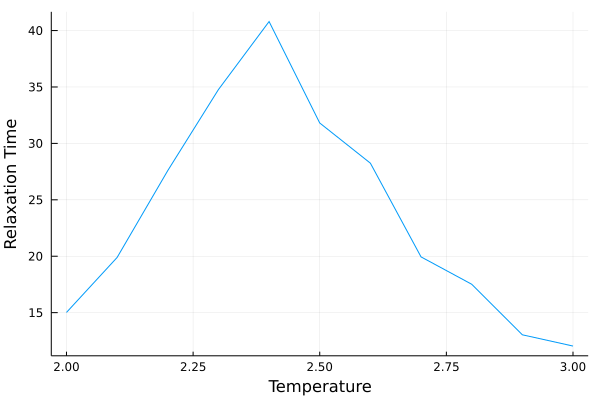

In [19]:
plot(2:0.1:3,tau,xlabel="Temperature",ylabel="Relaxation Time",legend=false)

Perform final runs with equilibration times $\geq 10\tau$ and data runs for lengths $\geq 20\tau$.For h= 0, calculate M, susceptibility $\chi$
\begin{equation}
\chi = (k_B T)^{-1}(<M^2> - <M>^2)
\end{equation}
and the specific heat $C$
\begin{equation}
C = (k_B T^2)^{-1}(<E^2> - <E>^2)
\end{equation}
as a function of $T$ for $T<T_c$ and $T>T_c$ where $T_c/J \approx 2.27$. Compare the magnetisation curve with the exact Onsager solution.

# Final Production Runs
Now we will do the production runs on $64x64$ lattice with the first $10\tau$ (at least) MC steps being discarded as they form the equilibration run. The next $20\tau$ (at least) MC steps will be used for averaging.

I choose $30$ log distributed temperatures spanning both above and below $T_c$, covering $3$ decades on both sides of $T_c$.

In [21]:
Tc = 2.269
tempset = zeros(30)
for i in 1:15
    tempset[i] = Tc - 10^(-(i-1)*0.2)
end
for j in 1:15
    tempset[j+15] = Tc + 10^(-(15-j)*0.2)
end

The function **main** is the piece of code that will run the core simulation.

In [22]:
function main(n::Int64,teq::Int64,tprod::Int64,tempset::Array{Float64,1},M::Int64)
    
    mag = zeros(size(tempset,1))
    onsager = zeros(size(tempset,1))
    specheat = zeros(size(tempset,1))
    suscep = zeros(size(tempset,1))
    Tdist = zeros(size(tempset,1))

    step = 1
    for temp in tempset
        beta = 1/temp
        magnetisation = zeros(tprod)
        tot_energy = zeros(tprod)
        
        for m in 1:M
            N,spin = initialize(n)
            ##EQUILIBRATION RUN
            for i in 1:teq
                mcstep!(n,N,beta,spin)
            end
        
            ##PRODUCTION RUN
            magnetisation_smp = zeros(Float64,tprod)
            tot_energy_smp = zeros(Float64,tprod)
            for i in 1:tprod
                mcstep!(n,N,beta,spin)
                magnetisation_smp[i] = calc_mag(N,spin)
                tot_energy_smp[i] = calc_tot_eng(n,N,spin)
            end
            magnetisation .= magnetisation .+ magnetisation_smp
            tot_energy .= tot_energy .+ tot_energy_smp
        end
        
        magnetisation .= magnetisation./M
        tot_energy .= tot_energy./M
        
        ##Calculate various propertier wrt temperature
        mag[step] = sum(magnetisation)/tprod
        k = 1.0/(sinh(2.0/temp)*sinh(2.0/temp))
        if(k<1.0)
            onsager[step] = (1 - k^2)^(1.0/8)
        else
            onsager[step] = 0.0
        end
        specheat[step] = beta*beta*variance(tot_energy)
        suscep[step] = beta*variance(magnetisation)
        Tdist[step] = abs(temp - Tc)
        
        step = step + 1
    end
    open("64x64","w") do io
		writedlm(io,hcat(mag,onsager,specheat,suscep,Tdist))
	end

    return mag,onsager,specheat,suscep,Tdist
end

main (generic function with 1 method)

Calculate $C$, $M$, and $\chi$ and fit it to
\begin{equation}
C \approx |T - T_c|^{-\alpha} \quad \quad M \approx (T_c - T)^{\beta} \quad \quad \chi \approx |T - T_c|^{-\gamma}
\end{equation}

$\rightarrow$ We choose $64x64$ lattice, $t_{eq} = 1000$ and $t_{prod} = 2500$. The code below executes the core simulation.

In [ ]:
mag64,onsager64,specheat64,suscep64,Tdist = main(64,1000,5000,tempset,50)

In [113]:
using DelimitedFiles
open("64x64","w") do io
	writedlm(io,hcat(mag64,onsager64,specheat64,suscep64,Tdist))
end

Lets compare the Magnetisation vs Temperature behaviour with the analytical solution provided by Onsager. Note that $J=1$.

\begin{eqnarray}
M &=& (1 - k^2)^{1/8} \\
k &=& \frac{1}{\sinh^2(2\beta)}
\end{eqnarray}

This is only valid when $0 \leq k \leq 1$, which gives us the critical temperature $T_c$ as $k$ becomes negative for for $T>T_c$.


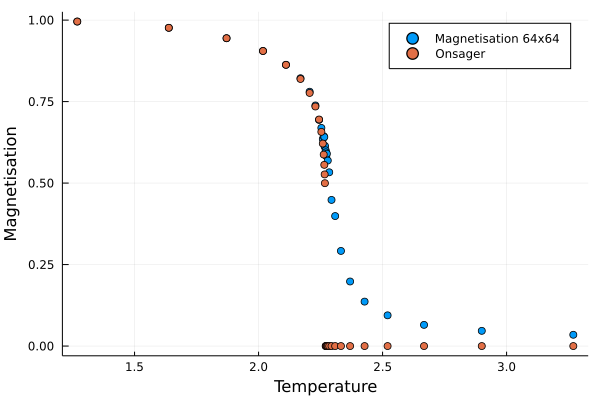

In [114]:
scatter(tempset,[mag64,onsager64],xlabel="Temperature",ylabel="Magnetisation",label=["Magnetisation 64x64" "Onsager"])

We clearly see that the order parameter does not drop abruptly to zero beyond $T_c$ but rather shows a gradual drop. This is finite size effect.

### Critical Exponents

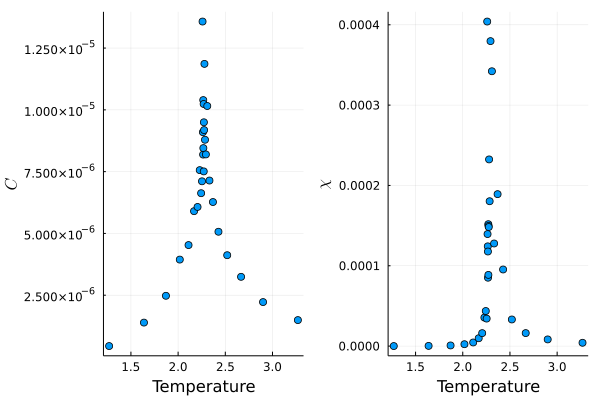

In [116]:
using LaTeXStrings

p1 = scatter(tempset,specheat64,xlabel="Temperature",ylabel=L"C",legend=false)
p2 = scatter(tempset,suscep64,xlabel="Temperature",ylabel=L"\chi",legend=false)

plot(p1, p2)# p3, p4,p5, layout = (3,3))

[1.02279782407306, 0.10041022016221136]
[0.008438209556778898, 0.0034976806222150295]
[2.037726044931056e-6, -1.565030808284666]
[5.3720959393502025e-8, 0.020684279573679576]
[-1.8885408226522624e-6]


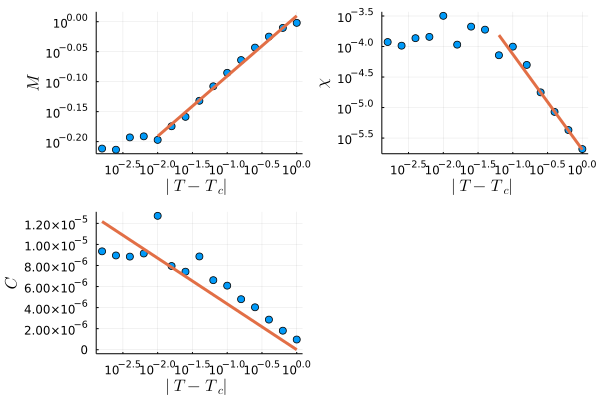

In [118]:
using LsqFit

@. powmodel(x, p) = p[1]*(x^p[2])
@. logmodel(x, p) = p[1]*log(x)


half = floor(Int64,size(tempset,1)/2)

specheat64_half = zeros(half)
suscep64_half = zeros(half)

for i in 1:half
    specheat64_half[i] = 0.5*(specheat64[i] + specheat64[size(tempset,1) + 1 - i])
    suscep64_half[i] = 0.5*(suscep64[i] + suscep64[size(tempset,1) + 1 - i])
end

p0 = [1.0,1.0]
specfit = curve_fit(logmodel, Tdist[1:15],specheat64_half, [-1.0])
susfit = curve_fit(powmodel, Tdist[1:4], suscep64_half[1:4], [-1.0,-1.0])
magfit = curve_fit(powmodel, Tdist[1:11], mag64[1:11], [1.0,1.0])

println(coef(magfit))
println(stderror(magfit))

println(coef(susfit))
println(stderror(susfit))

println(coef(specfit))
#println(stderror(specfit))

p1 = plot(xlabel=L"|T - T_c|", ylabel=L"M",xaxis=:log,yaxis=:log,legend=false)
p1 = plot!(Tdist[1:half], mag64[1:half],seriestype=:scatter)
p1 = plot!(Tdist[1:11], powmodel(Tdist[1:11],coef(magfit)), label="Fit", linewidth=3)

p2 = plot(xlabel=L"|T - T_c|", ylabel=L"\chi",xaxis=:log,yaxis=:log,legend=false)
p2 = plot!(Tdist[1:half], suscep64_half[1:half], seriestype=:scatter)
p2 = plot!(Tdist[1:7], powmodel(Tdist[1:7],coef(susfit)), linewidth=3)

p3 = plot(xlabel=L"|T - T_c|", ylabel=L"C",xaxis=:log,legend=false)
p3 = plot!(Tdist[1:half], specheat64_half[1:half], seriestype=:scatter)
p3 = plot!(Tdist[1:15], logmodel(Tdist[1:15],coef(specfit)), linewidth=3)

plot(p1,p2,p3)

iii) Perform simulations at $T=T_c$ at finite field $h$ (start with a value of the magnetic field where the mean field solution gives M= 0.3, and lower the field towards zero), to obtain the critical exponent $\delta$ given by
\begin{equation}
M \approx h^{1/\delta}
\end{equation}

$\rightarrow$ The mean field self-consistency equation gives
\begin{equation}
m = \tanh\beta (4Jm + h)
\end{equation}

At $T_c = 4J$, the mean field critical temperature, we put $m=0.3$ and we get $h=0.038$


In [103]:
hextset = zeros(20)
for i in 1:size(hextset,1)
    hextset[i] = 10^((log(0.038)/log(10)) - (i-1)*0.1)
end

In [104]:
using Plots
using CurveFit
using LaTeXStrings

function h_check_local_energy(i::Int64,n::Int64,h::Float64,spin::Array{Int64,1})
    energy=0.0
    p = mod(i-1,n) + 1 
    q = floor(Int64,(i-1)/n) + 1
    energy = spin[next(p,n) + n*(q-1)] + spin[prev(p,n) + n*(q-1)] + spin[p + n*(next(q,n)-1)] + spin[p + n*(prev(q,n)-1)]
    energy = -energy*spin[i]
    energy = energy - h*spin[i]
    return energy
end


function h_calc_tot_eng(n::Int64,N::Int64,h::Float64,spin::Array{Int64,1})
    toteng = 0.0
    for i in 1:N
        toteng = toteng + h_check_local_energy(i,n,h,spin)
    end
    toteng = 0.5*toteng/N
    return toteng
end

function h_mcmove!(n::Int64,N::Int64,beta::Float64,h::Float64,spin::Array{Int64,1})
    i = rand(1:N)
    deltaE = -2.0*h_check_local_energy(i,n,h,spin)
    spin[i] = -spin[i]
    acc_prob = exp(-beta*deltaE)
    if(rand() > acc_prob)
        spin[i] = -spin[i]
    end
end

function h_mcstep!(n::Int64,N::Int64,beta::Float64,h::Float64,spin::Array{Int64,1})
    for i in 1:N
        h_mcmove!(n,N,beta,h,spin)
    end
end



function h_main(n::Int64,teq::Int64,tprod::Int64,hextset::Array{Float64,1},M::Int64)
    mag = zeros(20)
    step = 1
    temp = 2.269
    beta = 1/temp
    step = 1
    for h in hextset
        magnetisation = zeros(tprod)
        for m in 1:M
            N,spin = initialize(n)
            for i in 1:teq
                h_mcstep!(n,N,beta,h,spin)
            end
            
            magnetisation_smp = zeros(tprod)
            for i in 1:tprod
                h_mcstep!(n,N,beta,h,spin)
                magnetisation_smp[i] = calc_mag(N,spin)
            end
            magnetisation .= magnetisation .+ magnetisation_smp
        end
        magnetisation .= magnetisation./M
        mag[step] = sum(magnetisation)/tprod
        step = step + 1
    end
    return mag
end

mag = h_main(64,1000,2500,hextset,10)

20-element Vector{Float64}:
 0.8048097851562499
 0.7946092382812502
 0.7811229492187501
 0.7698218359375
 0.7566008984375
 0.74883068359375
 0.73536146484375
 0.7211141210937501
 0.6946468554687499
 0.6998611523437499
 0.6928237890625002
 0.64547087890625
 0.68246109375
 0.6988266992187501
 0.6683730078125001
 0.6296493750000002
 0.6546574999999999
 0.6304583593749999
 0.6226856640625
 0.66197837890625

delta = 14.877285847042133


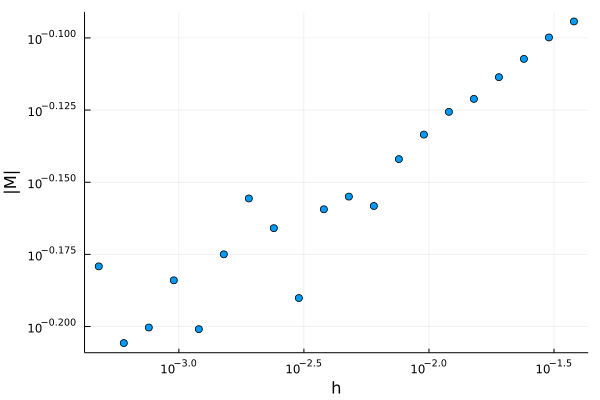

In [110]:
println("delta = ",1.0/linear_fit(arraylog(hextset[1:8]),arraylog(mag[1:8]))[2])
scatter(hextset,mag,xlabel="h",ylabel="|M|",xaxis=:log,yaxis=:log,legend=false)

The critical exponents that we have calculated are <br>

$\alpha$ = 0.09509872017005164 <br>
$\beta$ = 0.08930462775105526 <br>
$\gamma$ = 1.5198339051567131 <br>
$\delta$ = 14.877285847042133 <br>